# Machine learning for clean and affordable energy


In [1]:
import datetime as dt
import xmltodict
import pandas as pd
from catboost import Pool, CatBoostRegressor
from fmiopendata.wfs import download_stored_query
import seaborn as sns

sns.set_theme(rc={"figure.figsize": (18.7, 8.27)})


def date_range(start_date, end_date, max_days):
    current_date = start_date
    while (end_date - current_date).days >= max_days:
        chunk_end = current_date + dt.timedelta(days=max_days - 1)
        yield (current_date, chunk_end)
        current_date = chunk_end + dt.timedelta(days=1)
    yield (current_date, end_date)

# Weather data

Weather data is collected from [Finnish Meteorological Institute open data](https://en.ilmatieteenlaitos.fi/open-data) with [`fmiopendata`](https://github.com/pnuu/fmiopendata) Python library.


In [2]:
def get_weather_df(
    start_date: dt.date, end_date: dt.date, place: str = "Helsinki"
) -> pd.DataFrame:
    """Fetch weather data between given dates

    Args:
        start_date (dt.date): Start date of requested weather data
        end_date (dt.date): End date of requested weather data
        place (str, optional): Place of requested weather data. Defaults to "Helsinki".
    """
    weather_data = {}
    for start, end in date_range(start_date, end_date, 31):
        start_string = start.strftime("%Y-%m-%d") + "T00:00:00Z"
        end_string = end.strftime("%Y-%m-%d") + "T23:59:59Z"
        data_chunk = download_stored_query(
            "fmi::observations::weather::hourly::multipointcoverage",
            [
                "place=" + place,
                "starttime=" + start_string,
                "endtime=" + end_string,
            ],
        ).data
        weather_data.update(data_chunk)

    dates = []
    air_temperatures = []
    wind_speeds = []
    precipitation_amounts = []
    place_key = list(list(weather_data.values())[0].keys())[0]
    for datetime, data in weather_data.items():
        dates.append(datetime)
        air_temperatures.append(data[place_key]["Air temperature"]["value"])
        wind_speeds.append(data[place_key]["Wind speed"]["value"])
        precipitation_amounts.append(data[place_key]["Precipitation amount"]["value"])

    weather_df = pd.DataFrame(
        {
            "datetime": dates,
            "air temperatures": air_temperatures,
            "wind speeds": wind_speeds,
            "precipitation amounts": precipitation_amounts,
        }
    )

    return weather_df

# Energy data

Energy data is obtained from [ENTSO-E (European Network of Transmission System Operators for Electricity) API](https://transparency.entsoe.eu/load-domain/r2/totalLoadR2/show).


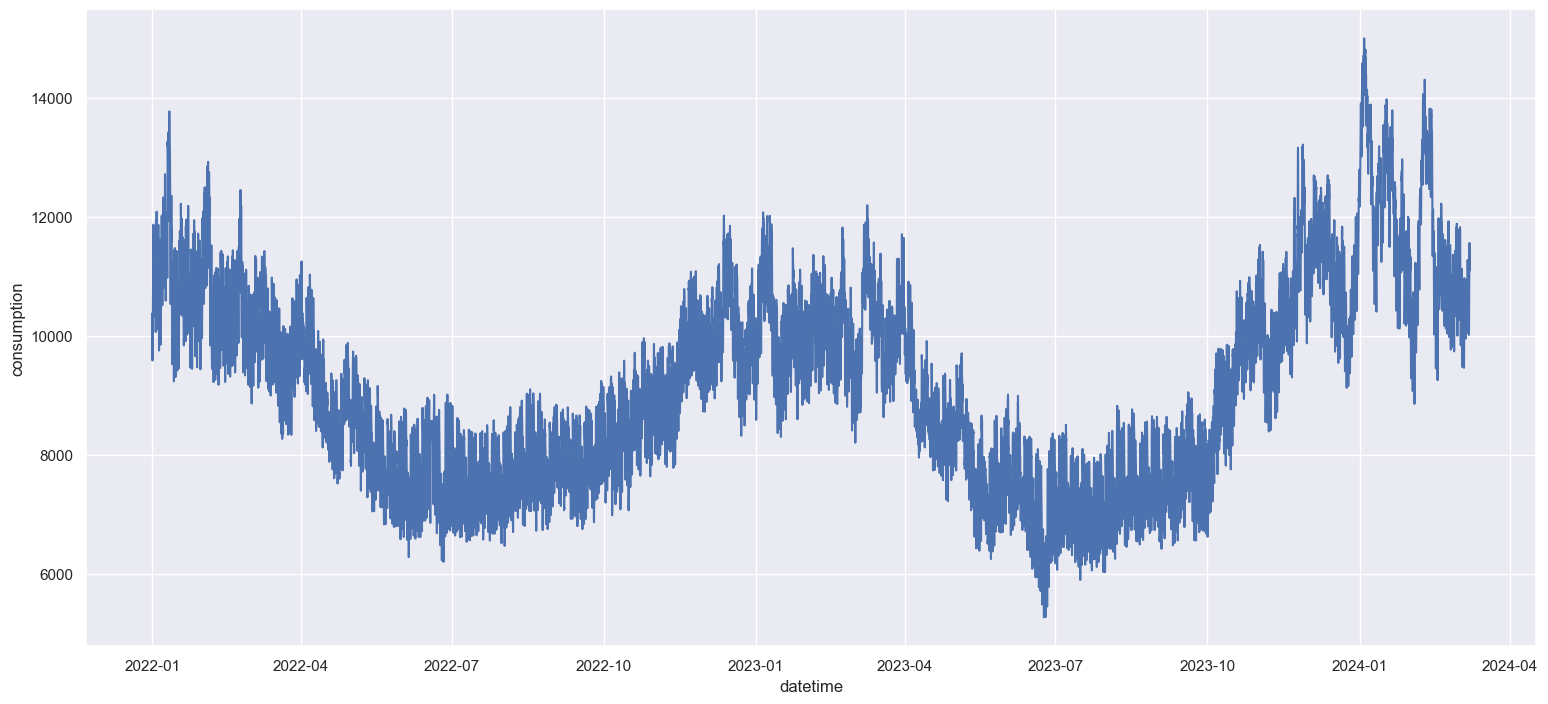

In [3]:
energy_data_years = list(range(2022, 2025))
data = []
for year in energy_data_years:
    with open(f"data/electricity-consumption/{year}.xml", "r") as file:
        data_string = file.read()
        yearly_data = xmltodict.parse(data_string)["GL_MarketDocument"]["TimeSeries"]
        data += yearly_data

energy_data = [day["Period"] for day in data]
hourly_means = {}

times = []
values = []

for day in energy_data:
    time = dt.datetime.strptime(
        day["timeInterval"]["start"], "%Y-%m-%dT%H:%MZ"
    ) + dt.timedelta(hours=2)
    if day["resolution"] == "PT60M":
        for hour in day["Point"]:
            hourly_means[time] = int(hour["quantity"])
            times.append(time)
            values.append(int(hour["quantity"]))
            time += dt.timedelta(hours=1)
    elif day["resolution"] == "PT15M":
        fifteen_min_means = [
            int(fifteen_min["quantity"]) for fifteen_min in day["Point"]
        ]
        i = 0
        while i < len(fifteen_min_means):
            hourly_means[time] = sum(fifteen_min_means[i : i + 4]) / 4
            times.append(time)
            values.append(sum(fifteen_min_means[i : i + 4]) / 4)
            time += dt.timedelta(hours=1)
            i += 4
    else:
        print("Unknown resolution", day["resolution"])

energy_df = pd.DataFrame({"datetime": times, "consumption": values})
ax = sns.lineplot(x=energy_df["datetime"], y=energy_df["consumption"])

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Daily energy consumption (MWh)')]

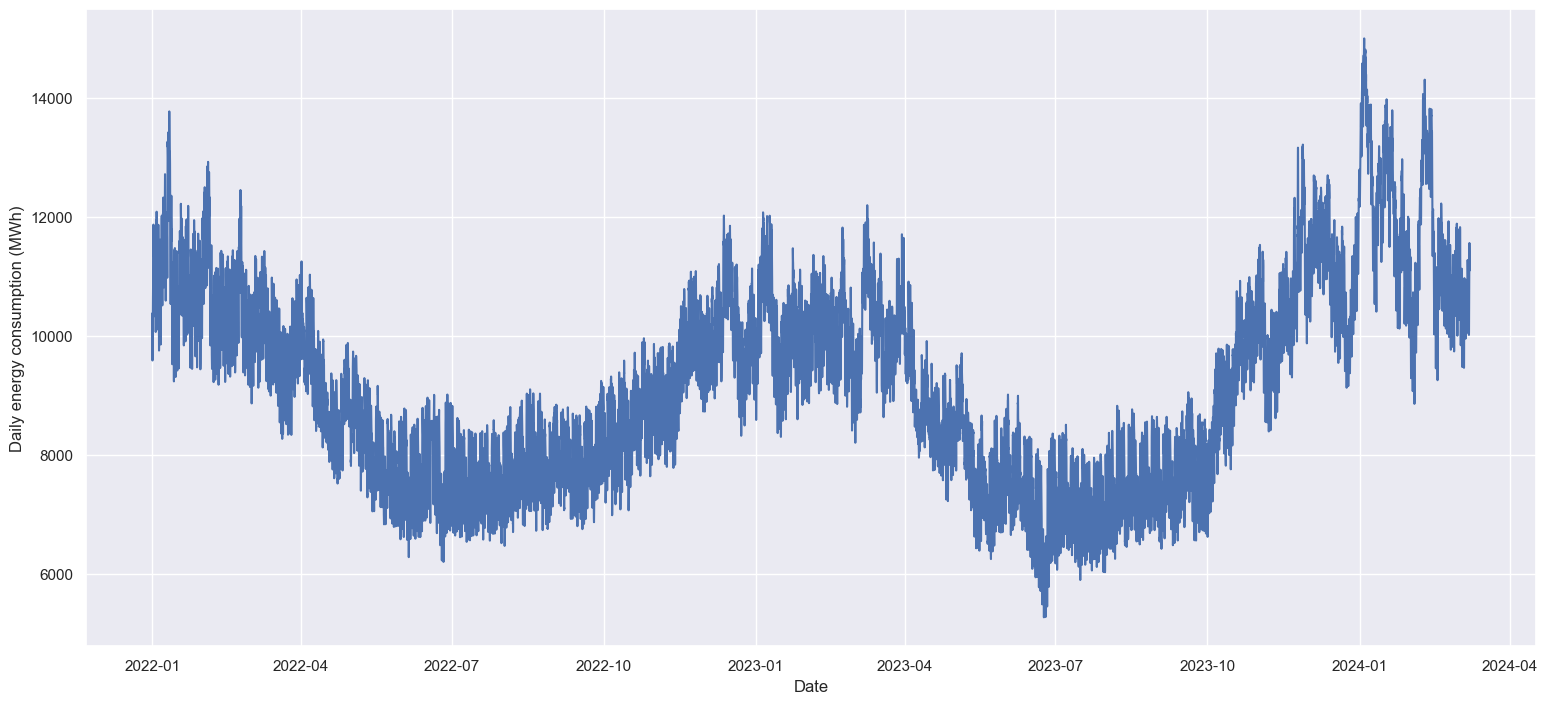

In [4]:
# Polished graph
ax = sns.lineplot(x=energy_df["datetime"], y=energy_df["consumption"])
ax.set(xlabel="Date", ylabel="Daily energy consumption (MWh)")

In [5]:
# Testing what the get_weather_df gives

start_date = dt.date(2023, 1, 1)
end_date = dt.date(2024, 3, 7)
tw = get_weather_df(start_date, end_date)

In [6]:
tw.describe()

,datetime,air temperatures,wind speeds,precipitation amounts
count,10368,10352.000000,10296.000000,10351.000000
mean,2023-08-04 23:30:00,5.333665,3.945037,0.090078
min,2023-01-01 00:00:00,-21.000000,0.200000,0.000000
25%,2023-04-18 23:45:00,-0.800000,2.600000,0.000000
50%,2023-08-04 23:30:00,3.000000,3.800000,0.000000
75%,2023-11-20 23:15:00,14.400000,5.000000,0.000000
max,2024-03-07 23:00:00,27.700000,12.700000,22.900000
std,NaN,9.404787,1.827491,0.557532


# Predictions

Predictions are made with [CatBoost library](https://catboost.ai/).


In [7]:
start_date = dt.date(2023, 1, 1)
end_date = dt.date(2024, 3, 6)

weather_data1 = get_weather_df(start_date, end_date).set_index("datetime")
weather_data2 = get_weather_df(start_date, end_date, "Kajaani").set_index("datetime")
weather_data3 = get_weather_df(start_date, end_date, "Vaasa").set_index("datetime")
dataframe = weather_data1.join(weather_data2, rsuffix="1").join(
    weather_data3, rsuffix="2"
)
dataframe = dataframe.loc[
    :,
    [
        "air temperatures",
        "air temperatures1",
        "air temperatures2",
        "wind speeds",
        "precipitation amounts",
    ],
]
dataframe["weekday"] = dataframe.index.weekday
dataframe["hour"] = dataframe.index.hour

In [8]:
train_data = dataframe.iloc[: int(0.8 * len(dataframe))]
test_data = dataframe.iloc[int(0.8 * len(dataframe)) :]
train_labels = [hourly_means[time] for time in train_data.index]
train_pool = Pool(train_data, train_labels, cat_features=["weekday", "hour"])
test_pool = Pool(test_data, cat_features=["weekday", "hour"])

model = CatBoostRegressor(iterations=19, depth=6, loss_function="RMSE")
model.fit(train_pool)
predictions = model.predict(test_pool)

print(predictions)

Learning rate set to 0.5
0:	learn: 1018.9160108	total: 48.5ms	remaining: 873ms
1:	learn: 823.7935148	total: 50.6ms	remaining: 430ms
2:	learn: 750.5197143	total: 52.7ms	remaining: 281ms
3:	learn: 647.8987305	total: 54.8ms	remaining: 206ms
4:	learn: 590.5205170	total: 56.8ms	remaining: 159ms
5:	learn: 570.6300114	total: 58.6ms	remaining: 127ms
6:	learn: 564.3074800	total: 60.3ms	remaining: 103ms
7:	learn: 561.6285665	total: 61.8ms	remaining: 85ms
8:	learn: 559.3432185	total: 63.6ms	remaining: 70.6ms
9:	learn: 553.9702325	total: 65.3ms	remaining: 58.8ms
10:	learn: 552.7580326	total: 67.2ms	remaining: 48.9ms
11:	learn: 550.9258772	total: 69.3ms	remaining: 40.4ms
12:	learn: 547.3952893	total: 71.1ms	remaining: 32.8ms
13:	learn: 545.7196497	total: 72.8ms	remaining: 26ms
14:	learn: 540.9140671	total: 74.7ms	remaining: 19.9ms
15:	learn: 538.4077057	total: 76.6ms	remaining: 14.4ms
16:	learn: 536.0882404	total: 78.6ms	remaining: 9.24ms
17:	learn: 534.3159789	total: 80.3ms	remaining: 4.46ms
18:	l

In [9]:
# forecast accuracy with MAPE

# mape results
# Helsinki 2024: (iterations=2, depth=2, loss_function="RMSE") -> 0.04859686603768826
# 3 weather points 2024: dataset: (18, 1, 'RMSE') = 0.050754643819194256
# 3 weather points 2024 v2: (19, 4, 'RMSE') = 0.05170260585403051
# 3 points, 2023-2024: (19, 6, 'RMSE') = 0.0961433526352825

mapes = {}

actual = [hourly_means[time] for time in test_data.index]

for i in range(1, 20):
    for k in range(10):
        for l in ["RMSE", "MAE"]:
            model = CatBoostRegressor(iterations=i, depth=k, loss_function=l)
            model.fit(train_pool)
            predictions = model.predict(test_pool)

            mape = 0
            for p in range(len(predictions)):
                mape += abs((actual[p] - predictions[p]) / actual[p]) / len(predictions)

            mapes[(i, k, l)] = mape

Learning rate set to 0.5
0:	learn: 1514.6069817	total: 903us	remaining: 0us
0:	learn: 1285.5438056	total: 1.14ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1093.7742564	total: 1.27ms	remaining: 0us
0:	learn: 1255.9097395	total: 1.73ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1053.0737644	total: 1.34ms	remaining: 0us
0:	learn: 1255.7986256	total: 29.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1037.3218765	total: 1.4ms	remaining: 0us
0:	learn: 1254.5345731	total: 2.15ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1025.3997705	total: 1.49ms	remaining: 0us
0:	learn: 1253.5383474	total: 1.84ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1022.1393029	total: 1.5ms	remaining: 0us
0:	learn: 1253.2999447	total: 2.27ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1018.9160108	total: 1.8ms	remaining: 0us
0:	learn: 1252.9771354	total: 2.47ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1011.6942306	total: 2.32ms	remaining: 0us
0:	learn: 1252.7948955	t

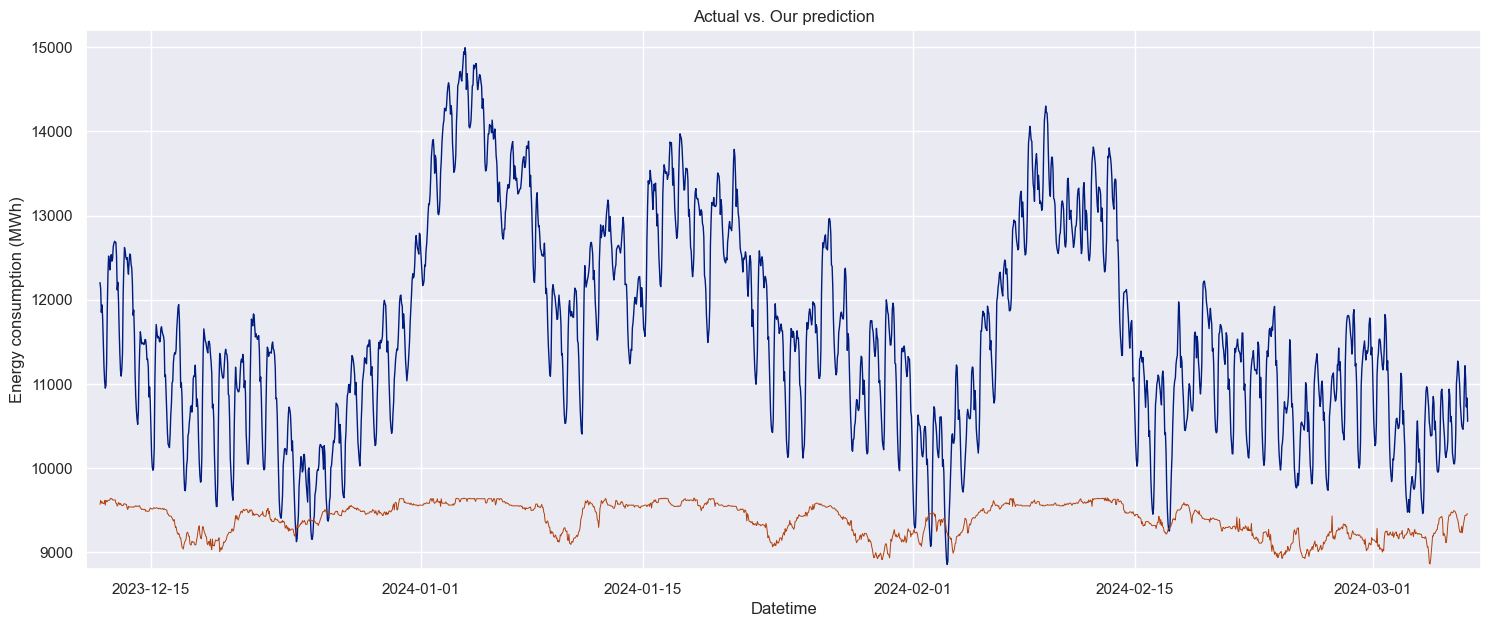

In [10]:
dr = pd.date_range(test_data.index.min(), test_data.index.max(), freq="h")

fin_pred = pd.read_csv("./data/165_2023-12-11T1900_2024-03-06T2300.csv", sep=",")

sns.set_palette("dark", 2)

ax = sns.lineplot(x=dr, y=actual, lw=1)

# show (0) our, (1) fingrid, (2) both
show = 0
title = "Actual "
if show > 0:
    ax = sns.lineplot(
        x=dr,
        y=fin_pred["consumption prediction"],
        data=fin_pred,
        linestyle="--",
        lw=0.9,
    )
    title += "vs. Fingrid "
if show % 2 == 0:
    ax = sns.lineplot(x=dr, y=predictions, lw=0.7)
    title += "vs. Our "
title += "prediction"

ax.set(
    title=title,
    xlabel="Datetime",
    ylabel="Energy consumption (MWh)",
    ylim=(8800, 15200),
)

ax.figure.set_size_inches(18, 7)
ax.margins(0.01)

In [11]:
# locate the smallest mean absolute percentage error
print(f"{min(mapes, key=mapes.get)} = {mapes[min(mapes, key=mapes.get)]}")


# Fingrid prediction accuracy
mapef = 0
for fp in range(len(fin_pred)):
    mapef += abs((actual[p] - fin_pred["consumption prediction"][p]) / actual[p]) / len(
        fin_pred
    )
print(mapef)

(16, 7, 'RMSE') = 0.09370254967310271
0.019667471934062507
